EKF Simulation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

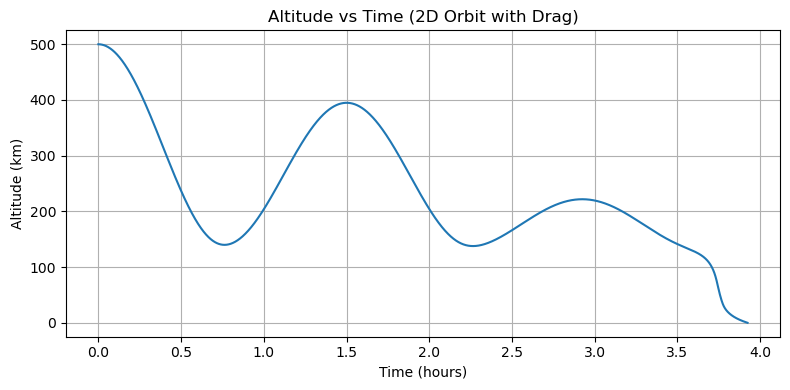

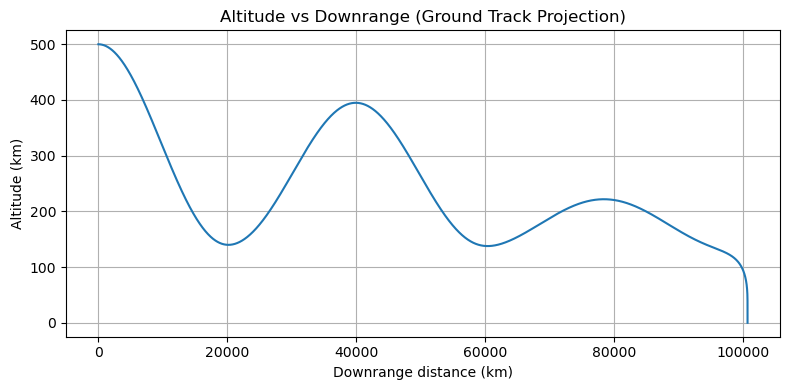

Final time: 3.92 hours
Final altitude: -0.0 km


In [78]:
# ----------------- Constants -----------------

Re = 6371e3                  # m, Earth radius
mu = 3.986004418e14          # m^3/s^2, Earth's GM

g0 = 9.81                    # m/s^2, reference gravity (not used directly now)
rho0 = 1.225                 # kg/m^3, sea-level density
H = 8500.0                   # m, scale height

beta = 45.0                  # kg/m^2, Starlink-like ballistic coefficient

# ----------------- Initial Orbit -----------------

h0 = 500e3                   # m, initial altitude (500 km)
r0 = Re + h0                 # m, initial radius from Earth center

# Place satellite on +x axis, tangential velocity along +y
x0 = r0
y0 = 0.0

# Circular orbit speed
v_circ = np.sqrt(mu / r0)    # m/s

# Apply a small retrograde delta-v to initiate deorbit
dv_retro = 103.0             # m/s, retrograde burn magnitude
vx0 = 0.0
vy0 = v_circ - dv_retro

state0 = np.array([x0, y0, vx0, vy0])

# Time settings
t0 = 0.0
tf = 200_000.0                # s, max sim time (a few orbits)
dt = 1.0                     # s, time step


# ----------------- Atmosphere -----------------

def atmosphere_density(h):
    """
    Exponential atmosphere as a function of altitude h (m).
    h <= 0 -> treat as at/under surface, just clamp.
    """
    if h < 0.0:
        h = 0.0
    return rho0 * np.exp(-h / H)


# ----------------- Dynamics -----------------

def dynamics(state):
    """
    state = [x, y, vx, vy]
    returns state_dot
    """
    x, y, vx, vy = state

    # Position / radius
    r = np.hypot(x, y)

    # Altitude above Earth's surface
    h = r - Re

    # Gravitational acceleration (central gravity)
    # a_g = -mu * r_hat / r^2 = -mu * r_vec / r^3
    if r == 0:
        raise ValueError("Radius r = 0, invalid state.")
    ax_g = -mu * x / r**3
    ay_g = -mu * y / r**3

    # Speed and drag
    v = np.hypot(vx, vy)

    if v > 1e-3 and h > 0:
        rho = atmosphere_density(h)
        drag_factor = 0.5 * rho * v / beta   # = 0.5 * rho * v^2 / (beta * v)
        ax_d = -drag_factor * vx
        ay_d = -drag_factor * vy
    else:
        ax_d = 0.0
        ay_d = 0.0

    # Total acceleration
    ax = ax_g + ax_d
    ay = ay_g + ay_d

    return np.array([vx, vy, ax, ay])


# ----------------- RK4 Integrator -----------------

def rk4_step(f, y, dt):
    k1 = f(y)
    k2 = f(y + 0.5 * dt * k1)
    k3 = f(y + 0.5 * dt * k2)
    k4 = f(y + dt * k3)
    return y + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)


# ----------------- Simulation Loop -----------------

times = [t0]
states = [state0.copy()]

state = state0.copy()
t = t0

while t < tf:
    x, y, vx, vy = state
    r = np.hypot(x, y)
    h = r - Re

    # Stop if we've reentered deeply (e.g. h < 0 -> "impact")
    if h <= 0.0 and t > t0:
        times.append(t)
        states.append(state.copy())
        break

    # Integrate one step
    state = rk4_step(dynamics, state, dt)
    t += dt

    times.append(t)
    states.append(state.copy())

states = np.array(states)
times = np.array(times)

# ----------------- Convert to useful quantities -----------------

x = states[:, 0]
y = states[:, 1]
r = np.hypot(x, y)
h = r - Re                  # altitude (m)

# "Downrange distance" along the surface (arc length)
theta = np.arctan2(y, x)    # angle from +x axis
theta_unwrapped = np.unwrap(theta)  # avoid jumps at ±pi
downrange = Re * (theta_unwrapped - theta_unwrapped[0])  # m

# ----------------- Plots -----------------

# Altitude vs time
plt.figure(figsize=(8, 4))
plt.plot(times / 3600.0, h / 1000.0)
plt.xlabel("Time (hours)")
plt.ylabel("Altitude (km)")
plt.title("Altitude vs Time (2D Orbit with Drag)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Ground track (downrange) vs altitude
plt.figure(figsize=(8, 4))
plt.plot(downrange / 1000.0, h / 1000.0)
plt.xlabel("Downrange distance (km)")
plt.ylabel("Altitude (km)")
plt.title("Altitude vs Downrange (Ground Track Projection)")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Final time: {times[-1]/3600.0:.2f} hours")
print(f"Final altitude: {h[-1]/1000.0:.1f} km")
